# Problem 2

In [17]:
import wrds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


#### 1)

In [3]:
amzn = db.raw_sql("select date, ret from crsp.dsf where permno in (84788) and date>='2010-01-01' and date<='2019-12-31'")
amzn.to_csv('amzn.csv')
mkt = db.raw_sql("select date, vwretd from crsp.dsi where date>='2010-01-01' and date<='2019-12-31'")
mkt.to_csv('mkt.csv')
rf = db.raw_sql("select caldt, tdyld from crsp.tfz_dly_rf2 where caldt>='2010-01-01' and caldt<='2019-12-31'")
rf.to_csv('rf.csv')

Data Cleaning

In [4]:
d1 = list(mkt['date'])
d2 = rf['caldt']
d2 = list(set(d2))
d2.sort()

In [5]:
# rf has multiple values for single dates -> take mean
rf = rf.set_index('caldt')
rf = [rf.loc[d2[i]].mean().item() for i in range(len(d2))]
rf = pd.DataFrame({'rf':rf, 'date':d2})
rf = rf.set_index('date')

In [6]:
# keep dates in d2 (and rf) that also are in d1
c2 = [d2[i] for i in range(len(d2)) if d2[i] in d1]
rf = rf.loc[c2]
# keep dates in d1 (amzn/mkt) that also are in c2 (rf)
d1 = [d1[i] for i in range(len(d1)) if d1[i] in d2]

In [7]:
# construct complete dataframe
data = amzn
mrkt = mkt.vwretd.squeeze()
data['mrkt'] = mrkt
data = data.set_index('date')
data = data.rename(columns={'ret':'amzn'})
data = data.loc[d1]
data['rf'] = rf.squeeze()
#dti = pd.DatetimeIndex(data.index)
#data['dti'] = dti
#data.set_index(dti)

#### 2)

In [8]:
# Assuming one month contains 20 trading days, we use rolling windows of 120 observations (6 trading months)
# for the the rolling estimates

# compute excess returns for amzn and mrkt
excess = data.copy(deep=True)
excess.amzn -= excess.rf
excess.mrkt -= excess.rf

In [21]:
betas = []
alphas = []

for i in range(120,len(excess)):
    train = excess.iloc[(i-120):i,:]
    x = np.asarray(train.iloc[:,1]).reshape(-1,1)
    y = np.asarray(train.iloc[:,0]).reshape(-1,1)
    lm_fit = LinearRegression().fit(x, y)
    betas.append(lm_fit.coef_.item())
    alphas.append(lm_fit.intercept_.item())


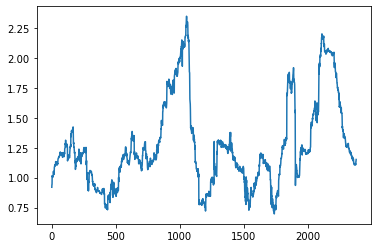

In [24]:
plt.plot(betas)